In [26]:
!pip install pydicom SimpleITK matplotlib --quiet

Slice shape: (128, 128)


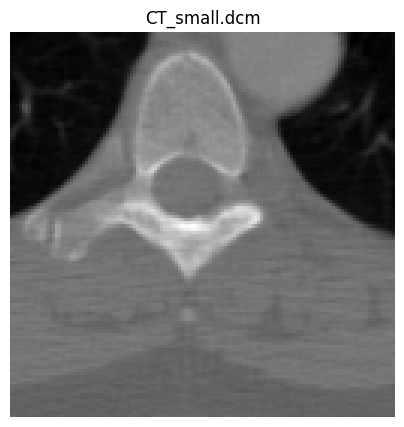

In [27]:
from pydicom.data import get_testdata_file
import pydicom, matplotlib.pyplot as plt

# Load the built-in test CT
path = get_testdata_file("CT_small.dcm")
ds   = pydicom.dcmread(path)
img  = ds.pixel_array  # a single 2D slice

print("Slice shape:", img.shape)
plt.figure(figsize=(5,5))
plt.imshow(img, cmap="gray")
plt.title("CT_small.dcm")
plt.axis("off")
plt.show()

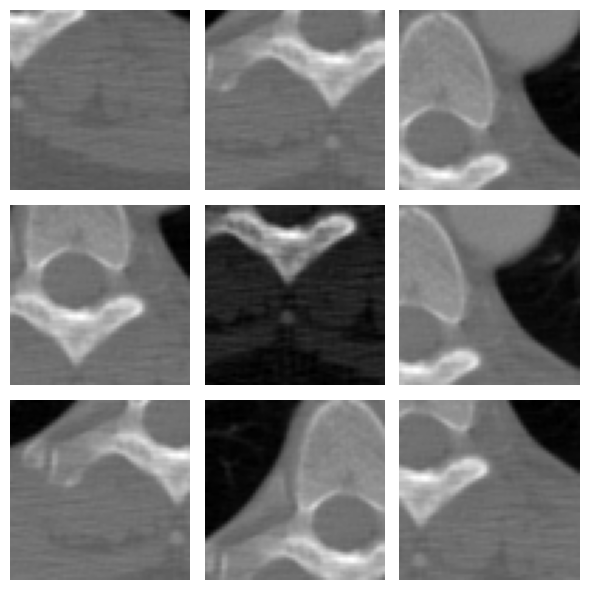

In [28]:
import numpy as np, os

patch_size = 64
n_patches  = 50
out_dir    = "patches"
os.makedirs(out_dir, exist_ok=True)

h, w = img.shape
for i in range(n_patches):
    y = np.random.randint(0, h - patch_size)
    x = np.random.randint(0, w - patch_size)
    patch = img[y:y+patch_size, x:x+patch_size]
    plt.imsave(f"{out_dir}/patch_{i:03d}.png", patch, cmap="gray")

# Display 9 example patches
fig, axes = plt.subplots(3,3, figsize=(6,6))
for ax, idx in zip(axes.flatten(), range(9)):
    ax.imshow(plt.imread(f"{out_dir}/patch_{idx:03d}.png"), cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()


Using device: cpu
Found 50 existing patches. Organizing for ImageFolder...
Organized 50 patches in patches_dataset/medical_patches/
Dataset size: 50 images
Number of batches: 1
Generator parameters: 3574656
Discriminator parameters: 2763520
Starting training...
Epoch 1 completed. Sample saved to results/fake_samples_epoch_01.png
Epoch 2 completed. Sample saved to results/fake_samples_epoch_02.png
Epoch 3 completed. Sample saved to results/fake_samples_epoch_03.png
Epoch 4 completed. Sample saved to results/fake_samples_epoch_04.png
Epoch 5 completed. Sample saved to results/fake_samples_epoch_05.png
Epoch 6 completed. Sample saved to results/fake_samples_epoch_06.png
Epoch 7 completed. Sample saved to results/fake_samples_epoch_07.png
Epoch 8 completed. Sample saved to results/fake_samples_epoch_08.png
Epoch 9 completed. Sample saved to results/fake_samples_epoch_09.png
Epoch 10 completed. Sample saved to results/fake_samples_epoch_10.png
Epoch 11 completed. Sample saved to results/fak

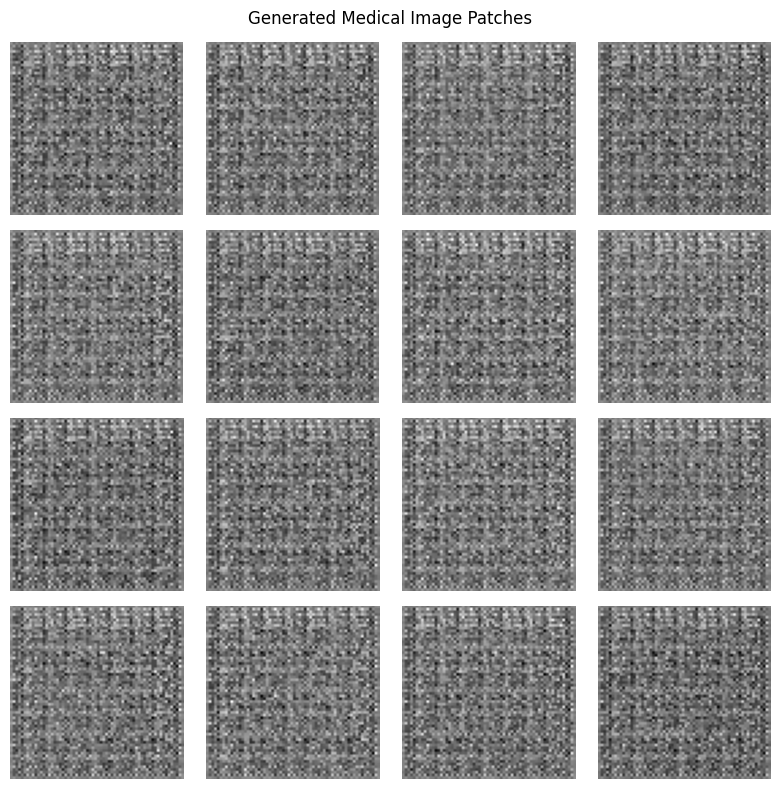

In [29]:
# 1) Imports and setup
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image, make_grid
import os
import numpy as np
import matplotlib.pyplot as plt

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 2) Hyperparameters
batch_size   = 64
image_size   = 64
nz           = 100
ngf          = 64
ndf          = 64
num_epochs   = 20
lr           = 0.0002
beta1        = 0.5

# 3) Create patches with proper ImageFolder structure
def create_patches_from_existing():
    """Create patches from existing patch files with proper ImageFolder structure"""
    # ImageFolder expects: patches_dataset/class_name/image_files
    patches_dataset_dir = "patches_dataset"
    class_dir = os.path.join(patches_dataset_dir, "medical_patches")
    os.makedirs(class_dir, exist_ok=True)

    # Check if patches already exist in the patches folder
    patches_dir = "patches"
    if os.path.exists(patches_dir):
        patch_files = [f for f in os.listdir(patches_dir) if f.endswith('.png')]
        if patch_files:
            print(f"Found {len(patch_files)} existing patches. Organizing for ImageFolder...")

            # Copy/move existing patches to proper structure
            import shutil
            for patch_file in patch_files:
                src = os.path.join(patches_dir, patch_file)
                dst = os.path.join(class_dir, patch_file)
                shutil.copy2(src, dst)

            print(f"Organized {len(patch_files)} patches in {class_dir}/")
            return patches_dataset_dir

    # If no existing patches, create synthetic ones
    print("No existing patches found. Creating synthetic medical-like patches...")

    # Create a synthetic medical-like image
    img = np.random.rand(512, 512) * 0.3 + 0.2  # Base noise

    # Add some structure (simulating medical image features)
    x, y = np.meshgrid(np.linspace(-1, 1, 512), np.linspace(-1, 1, 512))
    img += 0.3 * np.exp(-(x**2 + y**2) / 0.5)  # Gaussian blob
    img += 0.2 * np.sin(x * 5) * np.cos(y * 5)  # Some texture

    # Normalize to [0, 1]
    img = (img - img.min()) / (img.max() - img.min())

    # Create patches
    patch_size = 64
    n_patches = 200  # More patches for better training

    print(f"Creating {n_patches} synthetic patches...")
    h, w = img.shape
    for i in range(n_patches):
        y = np.random.randint(0, h - patch_size)
        x = np.random.randint(0, w - patch_size)
        patch = img[y : y + patch_size, x : x + patch_size]
        plt.imsave(f"{class_dir}/patch_{i:03d}.png", patch, cmap="gray")

    print(f"Created {n_patches} patches in {class_dir}/")
    return patches_dataset_dir

# Create or organize patches with proper structure
patches_root = create_patches_from_existing()

# 4) Create dataset + dataloader
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  # scale to [-1,1]
])

# Create dataloader with proper ImageFolder structure
try:
    dataset = datasets.ImageFolder(patches_root, transform=transform)
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    print(f"Dataset size: {len(dataset)} images")
    print(f"Number of batches: {len(dataloader)}")
except Exception as e:
    print(f"Error creating dataloader: {e}")
    print("Check that patches are organized in the correct structure:")
    print(f"  {patches_root}/")
    print(f"    medical_patches/")
    print(f"      patch_001.png")
    print(f"      patch_002.png")
    print(f"      ...")
    raise

# 5) Weight initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# 6) Generator network
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input Z -> (nz) x 1 x 1
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            # state: (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            # state: (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            # state: (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state: (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, 1, 4, 2, 1, bias=False),
            nn.Tanh()
            # output: 1 x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

# 7) Discriminator network
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input: 1 x 64 x 64
            nn.Conv2d(1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state: (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            # state: (ndf*2) x 16 x 16
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            # state: (ndf*4) x 8 x 8
            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            # state: (ndf*8) x 4 x 4
            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # output: scalar probability
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

# 8) Instantiate models & apply init
netG = Generator().to(device)
netG.apply(weights_init)
netD = Discriminator().to(device)
netD.apply(weights_init)

print("Generator parameters:", sum(p.numel() for p in netG.parameters()))
print("Discriminator parameters:", sum(p.numel() for p in netD.parameters()))

# 9) Loss and optimizers
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# 10) Training loop
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Create output directories
os.makedirs("results", exist_ok=True)
os.makedirs("models", exist_ok=True)

print("Starting training...")

for epoch in range(1, num_epochs + 1):
    for i, (real_images, _) in enumerate(dataloader, 1):
        # Train Discriminator
        netD.zero_grad()
        real_images = real_images.to(device)
        batch_size_i = real_images.size(0)

        # Train with real images
        labels_real = torch.full((batch_size_i,), 1., dtype=torch.float, device=device)
        output = netD(real_images)
        lossD_real = criterion(output, labels_real)
        lossD_real.backward()

        # Train with fake images
        noise = torch.randn(batch_size_i, nz, 1, 1, device=device)
        fake_images = netG(noise)
        labels_fake = torch.full((batch_size_i,), 0., dtype=torch.float, device=device)
        output = netD(fake_images.detach())
        lossD_fake = criterion(output, labels_fake)
        lossD_fake.backward()
        optimizerD.step()

        # Train Generator
        netG.zero_grad()
        labels_gen = torch.full((batch_size_i,), 1., dtype=torch.float, device=device)
        output = netD(fake_images)
        lossG = criterion(output, labels_gen)
        lossG.backward()
        optimizerG.step()

        if i % 10 == 0:  # Print more frequently for debugging
            print(f"Epoch [{epoch}/{num_epochs}] Step [{i}/{len(dataloader)}] "
                  f"Loss_D: {(lossD_real + lossD_fake).item():.4f} Loss_G: {lossG.item():.4f}")

    # Save sample generated images each epoch
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    grid = make_grid(fake, padding=2, normalize=True, nrow=8)
    save_image(grid, f"results/fake_samples_epoch_{epoch:02d}.png")

    print(f"Epoch {epoch} completed. Sample saved to results/fake_samples_epoch_{epoch:02d}.png")

# 11) Save final models
torch.save(netG.state_dict(), "models/generator.pth")
torch.save(netD.state_dict(), "models/discriminator.pth")
print("Training complete! Models saved in ./models/ and samples in ./results/")

# 12) Generate some final samples
print("Generating final samples...")
with torch.no_grad():
    sample_noise = torch.randn(16, nz, 1, 1, device=device)
    generated_samples = netG(sample_noise).detach().cpu()

# Display the results
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(generated_samples[i].squeeze(), cmap='gray')
    ax.axis('off')
plt.suptitle('Generated Medical Image Patches')
plt.tight_layout()
plt.savefig('results/final_generated_samples.png', dpi=150, bbox_inches='tight')
plt.show()

In [30]:
import os
import shutil
import glob

# Create a folder called "nodule" inside "patches"
nodule_dir = "patches/nodule"
os.makedirs(nodule_dir, exist_ok=True)
print(f"Created directory: {nodule_dir}")

# Find all .png files in the patches directory (not in subdirectories)
png_files = glob.glob("patches/*.png")
print(f"Found {len(png_files)} PNG files to move")

# Move every .png into the nodule folder
moved_count = 0
for png_file in png_files:
    filename = os.path.basename(png_file)
    destination = os.path.join(nodule_dir, filename)
    try:
        shutil.move(png_file, destination)
        moved_count += 1
        if moved_count <= 5:  # Show first 5 moves
            print(f"Moved: {png_file} -> {destination}")
    except Exception as e:
        print(f"Error moving {png_file}: {e}")

print(f"Successfully moved {moved_count} PNG files to {nodule_dir}")

# Verify the structure
if os.path.exists(nodule_dir):
    files_in_nodule = len([f for f in os.listdir(nodule_dir) if f.endswith('.png')])
    print(f"Verification: {files_in_nodule} PNG files now in {nodule_dir}")
else:
    print("Error: nodule directory was not created successfully")

Created directory: patches/nodule
Found 50 PNG files to move
Moved: patches/patch_042.png -> patches/nodule/patch_042.png
Moved: patches/patch_038.png -> patches/nodule/patch_038.png
Moved: patches/patch_007.png -> patches/nodule/patch_007.png
Moved: patches/patch_030.png -> patches/nodule/patch_030.png
Moved: patches/patch_021.png -> patches/nodule/patch_021.png
Successfully moved 50 PNG files to patches/nodule
Verification: 50 PNG files now in patches/nodule


In [31]:
!mkdir -p patches/nodule
!mv patches/*.png patches/nodule/
!ls patches/nodule

mv: cannot stat 'patches/*.png': No such file or directory
patch_000.png  patch_010.png  patch_020.png  patch_030.png  patch_040.png
patch_001.png  patch_011.png  patch_021.png  patch_031.png  patch_041.png
patch_002.png  patch_012.png  patch_022.png  patch_032.png  patch_042.png
patch_003.png  patch_013.png  patch_023.png  patch_033.png  patch_043.png
patch_004.png  patch_014.png  patch_024.png  patch_034.png  patch_044.png
patch_005.png  patch_015.png  patch_025.png  patch_035.png  patch_045.png
patch_006.png  patch_016.png  patch_026.png  patch_036.png  patch_046.png
patch_007.png  patch_017.png  patch_027.png  patch_037.png  patch_047.png
patch_008.png  patch_018.png  patch_028.png  patch_038.png  patch_048.png
patch_009.png  patch_019.png  patch_029.png  patch_039.png  patch_049.png


In [32]:
dataset = datasets.ImageFolder(root="patches", transform=transform)

In [33]:
from torch.utils.data import DataLoader

# Use the same transform you defined earlier
dataset = datasets.ImageFolder(root="patches", transform=transform)

# Create a DataLoader
dataloader = DataLoader(
    dataset,
    batch_size=16,    # start small so it’s quick to load
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

print(f"Found {len(dataset)} images in {dataset.classes[0]} class.")


Found 50 images in nodule class.


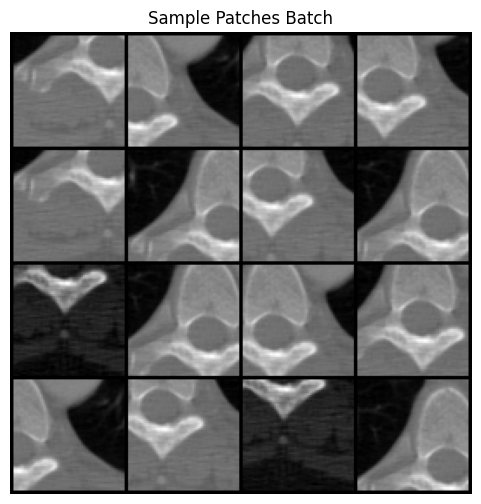

In [34]:
import matplotlib.pyplot as plt
import torchvision

# Grab one batch
images, _ = next(iter(dataloader))   # ignore labels (_)

# Make a grid of the first 16 patches
grid = torchvision.utils.make_grid(images, nrow=4, normalize=True)

# Plot it
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1, 2, 0), cmap="gray")
plt.axis("off")
plt.title("Sample Patches Batch")
plt.show()


In [35]:
# === DCGAN Training ===

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image, make_grid
import os

# 1) Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Training on:", device)

# 2) Hyperparameters
nz         = 100     # noise vector size
ngf        = 64      # generator feature maps
ndf        = 64      # discriminator feature maps
num_epochs = 10      # you can increase later
lr         = 0.0002
beta1      = 0.5
batch_size = 64      # should match your dataloader

# 3) Weight init
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias, 0)

# 4) Generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            # input: Z (nz x 1 x1)
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8), nn.ReLU(True),
            # state: (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4), nn.ReLU(True),
            # state: (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2), nn.ReLU(True),
            # state: (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf*2, ngf,   4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),   nn.ReLU(True),
            # state: (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, 1,      4, 2, 1, bias=False),
            nn.Tanh()  # output: 1 x 64 x 64 in [-1,1]
        )

    def forward(self, x):
        return self.net(x)

# 5) Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            # input: 1 x 64 x 64
            nn.Conv2d(1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*8, 1,     4, 1, 0, bias=False),
            nn.Sigmoid()  # scalar output
        )

    def forward(self, x):
        return self.net(x).view(-1)

# 6) Instantiate and init
netG = Generator().to(device)
netD = Discriminator().to(device)
netG.apply(weights_init)
netD.apply(weights_init)

# 7) Loss & Optimizers
criterion  = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# 8) Fixed noise for monitoring
fixed_noise = torch.randn(16, nz, 1, 1, device=device)

# 9) Prepare output folder
os.makedirs("results", exist_ok=True)

# 10) Training loop
for epoch in range(1, num_epochs+1):
    for i, (real_imgs, _) in enumerate(dataloader, 1):
        real_imgs = real_imgs.to(device)
        b_size    = real_imgs.size(0)
        # Train Discriminator on real
        netD.zero_grad()
        labels_real = torch.full((b_size,), 1., device=device)
        out_real    = netD(real_imgs)
        lossD_real  = criterion(out_real, labels_real)
        # Train Discriminator on fake
        noise       = torch.randn(b_size, nz, 1, 1, device=device)
        fake_imgs   = netG(noise)
        labels_fake = torch.full((b_size,), 0., device=device)
        out_fake    = netD(fake_imgs.detach())
        lossD_fake  = criterion(out_fake, labels_fake)
        lossD       = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()
        # Train Generator
        netG.zero_grad()
        labels_gen = torch.full((b_size,), 1., device=device)
        out_gen    = netD(fake_imgs)
        lossG      = criterion(out_gen, labels_gen)
        lossG.backward()
        optimizerG.step()

    # Save and display progress
    print(f"Epoch {epoch}/{num_epochs}  Loss_D: {lossD.item():.4f}  Loss_G: {lossG.item():.4f}")
    with torch.no_grad():
        sample = netG(fixed_noise).detach().cpu()
    grid = make_grid(sample, nrow=4, normalize=True)
    save_image(grid, f"results/epoch{epoch:02d}.png")

print("✅ Training complete! Check the `results/` folder for generated images.")


Training on: cpu
Epoch 1/10  Loss_D: 0.2595  Loss_G: 9.6817
Epoch 2/10  Loss_D: 0.3505  Loss_G: 15.6033
Epoch 3/10  Loss_D: 0.2558  Loss_G: 6.7567
Epoch 4/10  Loss_D: 0.0316  Loss_G: 7.3064
Epoch 5/10  Loss_D: 0.0628  Loss_G: 9.0265
Epoch 6/10  Loss_D: 0.7922  Loss_G: 26.0031
Epoch 7/10  Loss_D: 0.1140  Loss_G: 6.6011
Epoch 8/10  Loss_D: 0.0520  Loss_G: 7.2597
Epoch 9/10  Loss_D: 0.2140  Loss_G: 9.6780
Epoch 10/10  Loss_D: 0.0285  Loss_G: 8.7763
✅ Training complete! Check the `results/` folder for generated images.


In [37]:
# First, let's check what files actually exist
!ls -la /content/


# Check what files exist before copying
print("Files in /content:")
!ls -la /content/

print("\nLooking for notebook files:")
!find /content -name "*.ipynb" -type f

print("\nLooking for patches directory:")
!ls -la /content/patches/ 2>/dev/null || echo "No patches directory found"

print("\nLooking for results directory:")
!ls -la /content/results/ 2>/dev/null || echo "No results directory found"

print("\nLooking for models directory:")
!ls -la /content/models/ 2>/dev/null || echo "No models directory found"

# Copy files only if they exist
import os

# Copy notebook (find the correct name first)
if os.path.exists('/content/Untitled1.ipynb'):
    !cp /content/Untitled1.ipynb ./train_gan.ipynb
elif os.path.exists('/content/Untitled0.ipynb'):
    !cp /content/Untitled0.ipynb ./train_gan.ipynb
else:
    print("No notebook file found to copy")

# Copy directories only if they exist
if os.path.exists('/content/patches'):
    !cp -r /content/patches ./
    print("Copied patches directory")
else:
    print("No patches directory to copy")

if os.path.exists('/content/results'):
    !cp -r /content/results ./
    print("Copied results directory")
else:
    print("No results directory to copy")

# Create models directory and copy if exists
!mkdir -p models
if os.path.exists('/content/models') and os.listdir('/content/models'):
    !cp /content/models/* ./models/
    print("Copied models")
else:
    print("No models to copy")

# Check what we have now
print("\nCurrent directory contents:")
!ls -la

total 264296
drwxr-xr-x 1 root root      4096 Jun 20 12:57 .
drwxr-xr-x 1 root root      4096 Jun 20 12:48 ..
-rw-r--r-- 1 root root  61525722 Jun 20 12:57 complete_project.zip
drwxr-xr-x 4 root root      4096 Jun 17 13:36 .config
drwxr-xr-x 7 root root      4096 Jun 20 12:56 ct-lung-synthesis
-rw-r--r-- 1 root root  35709653 Jun 20 12:57 ct-lung-synthesis-full.zip
-rw-r--r-- 1 root root 112493116 Jun 20 12:57 ct-lung-synthesis.zip
drwxr-xr-x 2 root root      4096 Jun 20 12:56 models
-rw-r--r-- 1 root root  47032944 Jun 20 12:57 models.zip
drwxr-xr-x 3 root root      4096 Jun 20 12:56 patches
drwxr-xr-x 3 root root      4096 Jun 20 12:54 patches_dataset
-rw-r--r-- 1 root root    480418 Jun 20 12:57 patches.zip
-rw-r--r-- 1 root root       556 Jun 20 12:57 README.md
-rw-r--r-- 1 root root     13121 Jun 20 12:57 requirements.txt
drwxr-xr-x 2 root root      4096 Jun 20 12:56 results
-rw-r--r-- 1 root root  13316367 Jun 20 12:57 results.zip
drwxr-xr-x 1 root root      4096 Jun 17 13:37 sam

In [38]:
import os, torch

# 1) Make sure the folder exists
os.makedirs("models", exist_ok=True)

# 2) Save your trained networks
#    (if you used the names netG and netD in your session)
torch.save(netG.state_dict(), "models/generator.pth")
torch.save(netD.state_dict(), "models/discriminator.pth")

print("Models saved:", os.listdir("models"))


Models saved: ['generator.pth', 'discriminator.pth']


In [39]:
# List the top‐level of Colab's working dir
!ls -l /content

# List your repo folder
!ls -l /content/ct-lung-synthesis

# List your model, patch and result subfolders
!ls -l /content/ct-lung-synthesis/models
!ls -l /content/ct-lung-synthesis/patches
!ls -l /content/ct-lung-synthesis/results


total 264284
-rw-r--r-- 1 root root  61525722 Jun 20 12:57 complete_project.zip
drwxr-xr-x 7 root root      4096 Jun 20 12:56 ct-lung-synthesis
-rw-r--r-- 1 root root  35709653 Jun 20 12:57 ct-lung-synthesis-full.zip
-rw-r--r-- 1 root root 112493116 Jun 20 12:57 ct-lung-synthesis.zip
drwxr-xr-x 2 root root      4096 Jun 20 12:56 models
-rw-r--r-- 1 root root  47032944 Jun 20 12:57 models.zip
drwxr-xr-x 3 root root      4096 Jun 20 12:56 patches
drwxr-xr-x 3 root root      4096 Jun 20 12:54 patches_dataset
-rw-r--r-- 1 root root    480418 Jun 20 12:57 patches.zip
-rw-r--r-- 1 root root       556 Jun 20 12:57 README.md
-rw-r--r-- 1 root root     13121 Jun 20 12:57 requirements.txt
drwxr-xr-x 2 root root      4096 Jun 20 12:56 results
-rw-r--r-- 1 root root  13316367 Jun 20 12:57 results.zip
drwxr-xr-x 1 root root      4096 Jun 17 13:37 sample_data
total 516
drwxr-xr-x 8 root root   4096 Jun 20 13:15 ct-lung-synthesis
drwxr-xr-x 2 root root   4096 Jun 20 12:56 models
drwxr-xr-x 3 root roo